<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/PeriodicDomains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [0]:
# !rm *.py *.xml *.txt *.zip *.pvd *.vtu *.geo *.msh
try:
    from google.colab import files
except:
    print("This is not google.colab")
    
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
    !sudo apt-get update
    !sudo apt-get install -y gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


E: Package 'python-software-properties' has no installation candidate
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
G

#Load pre-defined functions

In [0]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

Load pre-defined functions from GitHub


# Working on the mesh

In [0]:
def RefineNearBoundary(mesh, nrefine):
    for j in range(nrefine):
      print("Refining ...")
      mesh.init(mesh.topology().dim()-1, mesh.topology().dim()) # Initialise facet to cell connectivity
      markers = MeshFunction("bool", mesh, mesh.topology().dim())
      for c in cells(mesh):
        for f in facets(c):
          if f.exterior():
            markers[c] = True
            break
      mesh = refine(mesh, markers)   
    print("Refined meshes: %d cells, %d vertices"%(mesh.num_cells(), mesh.num_vertices()))
    return mesh


geo_choice = 1;

if geo_choice==1:
    mesh_name = "CirclesInSquare"

    is_partition_function_exist = os.path.isfile('GetPartitionMarkers.py')
    if is_partition_function_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/GetPartitionMarkers.py

    is_geo_file_exist = os.path.isfile(mesh_name+'.geo')  
    if is_geo_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.geo

    # Create mesh from geo file by gmsh
    !gmsh -3 $mesh_name''.geo -o $mesh_name''.msh

    # Convert .msh to .xml using dolfin-convert
    !dolfin-convert $mesh_name''.msh $mesh_name''.xml

    clear_output()

    mymesh = Mesh(mesh_name+".xml");  

    from GetPartitionMarkers import *

    GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

    partition_marker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

    File("pmk_"+mesh_name+".xml")>>partition_marker
    
    phase, partion_list = CreatePhaseFunc(mymesh, [], [], partition_marker)
    
    File("Phase.pvd")<<phase
    
elif geo_choice==2:
  
    # clean files
    !rm *msh* *xml* *MAC*
    
    unzip_dir=!which unzip
    if len(unzip_dir)==0:
        !sudo apt-get install -y unzip

    # The periodic meshes were generated with Salome platform
    # ./runAppli -t -u /NOBACKUP/vdnguyen/SalomeMesh/SpheresInBox.py
    # The Salome script is available at
    # https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/SpheresInBox.py
    # TODO: The GMSH script for 3D does not work properly for now
    # https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/SpheresInBox.geo
    # but it should be fixed in the future
    
    # Download msh files and unzip
    !wget https://github.com/van-dang/MRI-Cloud/raw/mesh/SpheresInBox.msh.zip
    !wget https://github.com/van-dang/MRI-Cloud/raw/mesh/SpheresInBox_cmpt1.msh.zip  
    !unzip -q SpheresInBox.msh.zip
    !unzip -q SpheresInBox_cmpt1.msh.zip 
    
    # clear printscreen
    # clear_output()

    # convert msh to xml
    !dolfin-convert SpheresInBox.msh SpheresInBox.xml
    !dolfin-convert SpheresInBox_cmpt1.msh SpheresInBox_cmpt1.xml
    # create the phase function
    mymesh = Mesh("SpheresInBox.xml");
    cmpt_mesh = Mesh('SpheresInBox_cmpt1.xml')
    mymesh = RefineNearBoundary(mymesh, 1)
    
    evengroup = []
    oddgroup = [cmpt_mesh]
    phase, partion_list, partition_marker = CreatePhaseFunc(mymesh, evengroup, oddgroup, None)                

    File("Phase.pvd")<<phase
    
CheckAndCorrectPeriodicity(mymesh, 0, 1e-6)
CheckAndCorrectPeriodicity(mymesh, 1, 1e-6)
CheckAndCorrectPeriodicity(mymesh, 2, 1e-6)

Extracting cell markers from: CirclesInSquare.msh ...
Extracted successfully on: 6610 elements
Partition marker list: ['1', '0']
Wrote to: pmk_CirclesInSquare.xml
Check and correct the periodicity in direction 0
  The maximum error in y-component is: 1.3322676295501878e-15
  The maximum error in z-component is: 0
  The mesh was successfully corrected for this direction.
Check and correct the periodicity in direction 1
  The maximum error in x-component is: 1.3322676295501878e-15
  The maximum error in z-component is: 0
  The mesh was successfully corrected for this direction.
Check and correct the periodicity in direction 2
  Direction 2 is invalid


# Solve the Bloch-Torrey equation

In [0]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [10000]
for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.stype='PGSE'                                # sequence type
    mri_para.bvalue = bvalue;                            # bvalue
    mri_para.delta, mri_para.Delta = 10000, 13000           # time sequence
    mri_para.set_gradient_dir(mymesh, 1, 1, 0)           # gradient direction

    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 

    mri_para.Apply()
    mri_simu.k = 100;                                    # time-step size
    mri_simu.nskip = 5;                                  # frequency to print ouputs
    mydomain = MyDomain(mymesh, mri_para)
    mydomain.phase = phase 
    mydomain.PeriodicDir = [1, 1, 0];             # Direction of the periodicity
    mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = True              # Confirm if the mesh is multiple
    ################################################################################
    # mydomain.kappa_e_scalar = 5e-4;
    mydomain.kappa = 1e-5;
    mydomain.Apply()   # Call Apply before setting the diffusion tensor
    ################################################################################
    # Impose the diffusion coefficient
    mydomain.D  = 3e-3;
    #################################################################################

    # linsolver = PETScLUSolver("mumps")
    linsolver = KrylovSolver("bicgstab")
    linsolver.parameters["absolute_tolerance"] = 1e-4
    linsolver.parameters["relative_tolerance"] = 1e-4
    linsolver.parameters["maximum_iterations"] = 10000
    
    mri_simu.solve(mydomain, mri_para, linsolver)

    Post_processing(mydomain, mri_para, mri_simu, plt)    

Domain size: xmin=-5.000000, ymin=-5.000000, zmin=0.000000, xmax=5.000000, ymax=5.000000, zmax=0.000000
Function Space for Two-compartment Domains has 4 components
(ur0, ui0, ur1, ur1): r-real, i-imaginary
Initialize a standard function space.
The pseudo-periodic BCS are weakly imposed.
The mesh does not need to be periodic.
t:   0.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 0.00%
t: 500.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 2.16%
t: 1000.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 4.33%
t: 1500.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 6.49%
t: 2000.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 8.66%
t: 2500.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 10.82%
t: 3000.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 12.99%
t: 3500.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 15.15%
t: 4000.00  T: 23000.00 dt: 100.0 qvalue: 1.017095e-04 Completed 17.32%
t: 4500.00  T: 23000.00 dt: 100.

DEBUG:matplotlib.axes._base:update_title_pos


[0, 1, 3, 5, 7, 9, 11, 13, 15, 17]


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


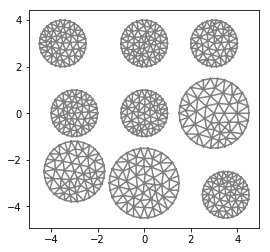

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


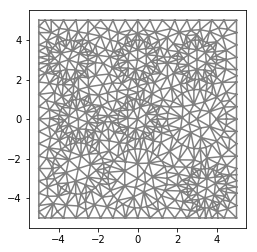

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


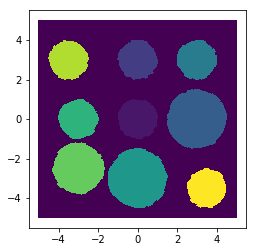

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


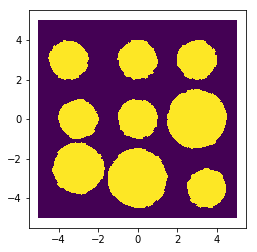

In [0]:
rectangle = Rectangle(Point(-5., -5.), Point(5., 5.))
cir_coors=[(0,0,1), (0,3,1), (3,0,1.5), (3,3,1), (0,-3,1.5), (-3,0,1), (-3,-2.5,1.3), (-3.5, 3, 1.0), (3.5, -3.5, 1.0)]

submesh_list=[];
domain = rectangle
for i in range(0, len(cir_coors)):
  circle = Circle(Point(cir_coors[i][0],cir_coors[i][1]), cir_coors[i][2], segments=30)
  rectangle.set_subdomain(i+1, circle)
  rectangle = rectangle - circle
  circle_mesh = generate_mesh(circle, 5)
  submesh_list.append(circle_mesh)

plt.figure()
for i in range(0, len(submesh_list)):
    plot(submesh_list[i])
  
domain.set_subdomain(5, rectangle)
mesh = generate_mesh(domain, 15) # 15 is the resolution
plt.figure(); plot(mesh)

mymesh = mesh

evengroup = []
oddgroup = submesh_list
phase, partion_list, partition_marker = CreatePhaseFunc(mymesh, evengroup, oddgroup, None)                

print(partion_list)
plt.figure();
plot(partition_marker);
plt.figure();
plot(phase);


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


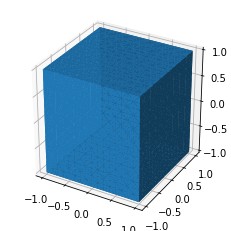

In [0]:
mesh = BoxMesh(Point(-1,-1,-1), Point(1,1,1),2,2,2)

  
mesh = RefineNearBoundary(mesh, 3)  
V=FunctionSpace(mesh, 'CG',1)
one=Function(V)
one.vector()[:]=1;
File("one.pvd")<<one
plot(mesh)